In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
#sets all plt graphs to a default size
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
data = pd.read_excel("default of credit card clients.xls", skiprows = 1)
data.shape

(30000, 25)

In [3]:
data = data.set_index('ID')
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
#get column names as predictors
Xnames = data.columns.values[1:-1]
Xnames

array([u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE', u'PAY_0', u'PAY_2',
       u'PAY_3', u'PAY_4', u'PAY_5', u'PAY_6', u'BILL_AMT1', u'BILL_AMT2',
       u'BILL_AMT3', u'BILL_AMT4', u'BILL_AMT5', u'BILL_AMT6', u'PAY_AMT1',
       u'PAY_AMT2', u'PAY_AMT3', u'PAY_AMT4', u'PAY_AMT5', u'PAY_AMT6'], dtype=object)

In [5]:
#create train/test mask
itrain, itest = train_test_split(xrange(data.shape[0]), train_size=0.6)
mask=np.ones(data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [6]:
#optimizing cv

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

#set parameters
parameters = {"n_estimators": range(1, 20)}
clfForest = RandomForestClassifier()

clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       data, Xnames, 'default payment next month', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')   

C:\Users\Alvin\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'n_estimators': 19} 0.461689389191 [mean: 0.39323, std: 0.00758, params: {'n_estimators': 1}, mean: 0.31167, std: 0.01339, params: {'n_estimators': 2}, mean: 0.42129, std: 0.02197, params: {'n_estimators': 3}, mean: 0.36467, std: 0.02281, params: {'n_estimators': 4}, mean: 0.43030, std: 0.00818, params: {'n_estimators': 5}, mean: 0.39435, std: 0.01321, params: {'n_estimators': 6}, mean: 0.45312, std: 0.01803, params: {'n_estimators': 7}, mean: 0.41233, std: 0.01606, params: {'n_estimators': 8}, mean: 0.44413, std: 0.02318, params: {'n_estimators': 9}, mean: 0.42236, std: 0.01831, params: {'n_estimators': 10}, mean: 0.45828, std: 0.01065, params: {'n_estimators': 11}, mean: 0.43411, std: 0.01694, params: {'n_estimators': 12}, mean: 0.45381, std: 0.01492, params: {'n_estimators': 13}, mean: 0.43483, std: 0.01132, params: {'n_estimators': 14}, mean: 0.46014, std: 0.02042, params: {'n_estimators': 15}, mean: 0.44521, std: 0.01392, params: {'n_estimators': 16}, mean: 0.4528

The results of the random forest classifier give us a 99% accuracy on the training data and a 81% accuracy on the test data.  This means that the model is overfitting, which is very common with the random forest classifier.  I'll do some fine tuning with the model later with techniques such as tree pruning.  

![hwimages](./images/confusionmatrix.png)
The above image shows what the confusion matrix in the last cell means.  When building machine learning models, there will always be inaccuracies.  In some cases, however, the kind of inaccuracy matters.  For example, if you are trying to predict if a patient has cancer, the model will need to be more conservative and should lean towards classifying patients as having cancer versus not having it -- this means having more False Positives than False Negatives).   In this case, do false positives and false negatives matter?  Credit companies would want to charge customers with a higher probability of default a higher premium.  This means that evaluating the probability would be more useful than the classification itself.  Let's do that.

## Relative Importance

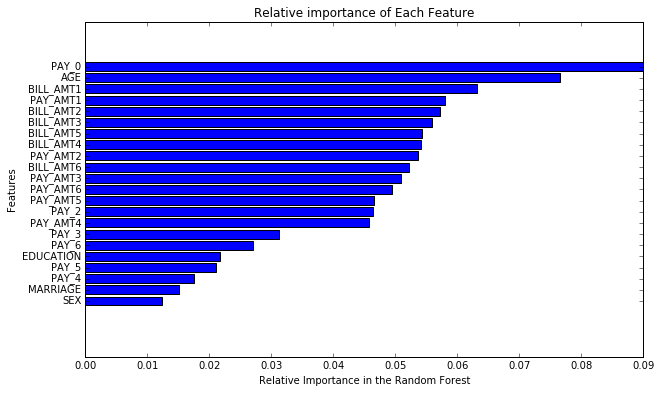

In [39]:
importance_list = clfForest.feature_importances_
name_list = Xnames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [8]:
#len(clfForest.predict_proba(Xtest))
prob_model = data[~mask][['default payment next month']]
prob_default = [x[1] for x in clfForest.predict_proba(Xtest)]
prob_model['Probability of default'] = pd.Series(prob_default)
prob_model.head()

,default payment next month,Probability of default
ID,,
1,1,0.105263
4,0,0.105263
5,0,0.631579
7,0,0.052632
12,0,0.263158


In [35]:
def test_probs(df, lowprob, highprob): 
    probtest = df[df['Probability of default'] > lowprob][df['Probability of default'] < highprob] 
    return float(len(probtest[probtest['default payment next month'] == 1]))/len(probtest)
parameters = np.linspace(0,1,11) 
parameter_list = [] 
pct_list = []
for i in range(len(parameters)-1): 
    parameter_list.append(str(parameters[i]) + '-' + str(parameters[i+1])) 
    pct_list.append(test_probs(prob_model, parameters[i], parameters[i+1])) 
model_evaluation_df = pd.DataFrame(dict(zip(['Probability range', 'Default percentage'], [parameter_list, pct_list]))) 
model_evaluation_df

C:\Users\Alvin\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,Default percentage,Probability range
0,0.199158,0.0-0.1
1,0.210720,0.1-0.2
2,0.221364,0.2-0.3
3,0.231250,0.3-0.4
4,0.216418,0.4-0.5
5,0.275362,0.5-0.6
6,0.226601,0.6-0.7
7,0.240876,0.7-0.8
8,0.223684,0.8-0.9
9,0.222222,0.9-1.0


Model is overfit!  It does not seem to have any legitimate predictive power.  The next step is to tweak the model and prevent overfitting - we can do this with feature engineering to avoid collinearity between features (such as the Pay_AMT and Bill_AMT variables), as well as setting a maximum limit for tree nodes.  